## Import Packages

In [16]:
import cv2
import sys
import os

import numpy as np
import scipy.sparse
import scipy.sparse.linalg

%matplotlib inline
import matplotlib.pyplot as plt

## LIME Algorithm

### Solve D.E.

In [17]:
def solve_linear_equation(th, wx, wy, alpha):
    """
    th: a matrix, initial illumination estimate T~ (i.e. T hat), shape=(h, w)
    wx: a matrix, means Wd~(x) of equation 19 (horizontal), shape=(h, w)
    wy: a matrix, means Wd~(x) of equation 19 (vertical), shape=(h, w)
    alpha: alpha is the coefficient to balance the involved two terms
    return T
    """

    # get image height and width
    h = th.shape[0]
    w = th.shape[1]
    k = w * h

    # get the C order vector t~ (i.e. flatten the matrix row by row)
    th_vec = th.flatten('C')

    # The equation 19 can be expressed as Ax=b (where x=t, b=t~)，thus matrix A is needed
    dy = alpha * wy
    dx = alpha * wx
    dxa = np.hstack([dx[:, -1].reshape(-1, 1), dx[:, 0:-1]])  # dx ahead
    dya = np.vstack([dy[-1, :].reshape(1, -1), dy[0:-1, :]])  # dy ahead

    # get the C order vector (i.e. flatten the matrix row by row)
    dy_vec = dy.flatten('C')
    dx_vec = dx.flatten('C')
    dxa_vec = dxa.flatten('C')
    dya_vec = dya.flatten('C')

    dyd1 = -np.vstack([dy[-1, :].reshape(1, -1), np.zeros((h - 1, w))]).flatten('C')
    dyd2 = -np.vstack([dya[1:, :], np.zeros((1, w))]).flatten('C')
    dyd3 = -np.vstack([np.zeros((1, w)), dy[0:-1, :]]).flatten('C')
    dyd4 = -np.vstack([np.zeros((h - 1, w)), dya[0, :].reshape(1, -1)]).flatten('C')
    ay = scipy.sparse.spdiags(np.array([dyd1, dyd2, dyd3, dyd4]), np.array([-k + w, -w, w, k - w]), k, k)

    dxd1 = -np.hstack([dx[:, -1].reshape(-1, 1), np.zeros((h, w - 1))]).flatten('C')
    dxd2 = -np.hstack([dxa[:, 1:], np.zeros((h, 1))]).flatten('C')
    dxd3 = -np.hstack([np.zeros((h, 1)), dx[:, 0:-1]]).flatten('C')
    dxd4 = -np.hstack([np.zeros((h, w - 1)), dxa[:, 0].reshape(-1, 1)]).flatten('C')
    ax = scipy.sparse.spdiags(np.array([dxd1, dxd2, dxd3, dxd4]), np.array([-w + 1, -1, 1, w - 1]), k, k)

    dig = scipy.sparse.spdiags(np.array([dx_vec + dy_vec + dxa_vec + dya_vec + 1]), np.array([0]), k, k)
    a = ax + ay + dig

    # The resulting object is an approximation to the inverse of A
    m = scipy.sparse.linalg.spilu(a.tocsc())
    # construct a linear operator
    m2 = scipy.sparse.linalg.LinearOperator((k, k), m.solve)
    # use preconditioned conjugate gradient method to solve the linear system Ax=b (where A=a, x=t, b=t~)
    t, info = scipy.sparse.linalg.bicgstab(a, th_vec, tol=1e-1, maxiter=2000, M=m2)

    if info != 0:
        print('warning: convergence to tolerance not achieved')

    t = t.reshape((h, w), order='C')

    # clip negative numbers & normalize
    t = np.clip(t, 0, sys.maxsize)
    t = t / (np.max(t) + lime_eps)

    return t

### LIME Function

In [27]:
#  a very small constant to avoid the zero denominator
lime_eps = 1e-3


# lime algorithm
def lime(image, weight_strategy=2, alpha=0.5, gamma=0.8, rho=2, win_size=5):
    # get raw image size
    h = image.shape[0]
    w = image.shape[1]

    # down-sampling the image make algorithm faster
    sf = 0.5  # scale factor
    dh = int(h * sf)
    dw = int(w * sf)
    small_img = cv2.resize(image, (dw, dh), interpolation=cv2.INTER_AREA)

    # normalize the values to [0, 1]
    small_img = small_img / 255

    # estimate initial illumination map T^ on L via Eq.(2)
    th = np.max(small_img, axis=2)

    # compute delta t_hat
    th_h = np.hstack([np.diff(th, axis=1), (th[:, 0] - th[:, -1]).reshape(-1, 1)])
    th_v = np.vstack([np.diff(th, axis=0), (th[0, :] - th[-1, :]).reshape(1, -1)])

    # constructing weight matrix
    if weight_strategy == 1:
        wh = np.ones((dh, dw))
        wv = np.ones((dh, dw))
    elif weight_strategy == 2:
        wh = 1 / (np.abs(th_h) + lime_eps)
        wv = 1 / (np.abs(th_v) + lime_eps)
    elif weight_strategy == 3:
        hk = np.exp(-np.array(range(win_size)) / (2 * (rho ** 2))).reshape(1, win_size)
        vk = hk.reshape(win_size, -1)
        sum_val = np.sum(hk)
        wh = sum_val / (np.abs(cv2.filter2D(th_h, -1, hk, anchor=(0, 0))) + lime_eps)
        wv = sum_val / (np.abs(cv2.filter2D(th_v, -1, vk, anchor=(0, 0))) + lime_eps)
    elif weight_strategy == 4:
        # a weight strategy in paper 'A New Image Contrast Enhancement Algorithm using Exposure Fusion Framework'
        wh = 1 / (np.abs(cv2.filter2D(th_h, -1, np.ones((1, win_size)), anchor=(0, 0))) + lime_eps)
        wv = 1 / (np.abs(cv2.filter2D(th_v, -1, np.ones((win_size, 1)), anchor=(0, 0))) + lime_eps)
    else:
        # default weight strategy (i.e. weight strategy 2)
        wh = 1 / (np.abs(th_h) + lime_eps)
        wv = 1 / (np.abs(th_v) + lime_eps)

    # compute w
    wx = wh / (np.abs(th_h) + lime_eps)
    wy = wv / (np.abs(th_v) + lime_eps)

    # Refine illumination map T based on T^ via sped-up solver Eq.(19)
    t = solve_linear_equation(th, wx, wy, alpha)

    # Gamma correction on T via T=T^gamma
    t = np.power(t, gamma)
    t = np.expand_dims(t, axis=2) + lime_eps

    # enhance image L using T according to L = R * T (i.e. R = L / T)
    r = small_img / t

    # denoising and recomposing,  denoise R by BM3D (Rd) and recompose via Eq.(24)
    # f = r*t + rd*(1-t)

    # convert float image to uint8
    r = r * 255
    r = np.clip(r, 0, 255)
    r = np.fix(r).astype(np.uint8)

    # up-sampling the image
    r = cv2.resize(r, (w, h), interpolation=cv2.INTER_CUBIC)

    return r

## Testing the algorithm

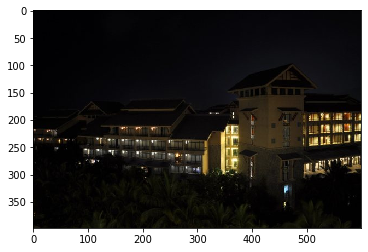

In [28]:
raw_image = cv2.imread("images/test-img.jpg")
raw_image = cv2.cvtColor(raw_image, cv.COLOR_BGR2RGB)
plt.figure(figsize=(16,4))
plt.imshow(raw_image)

In [29]:
img_ws1 = lime(raw_image, weight_strategy=1)

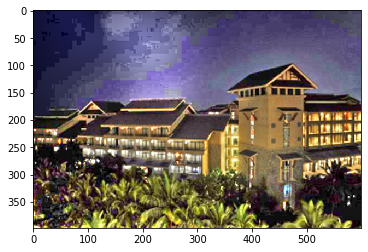

In [30]:
plt.figure(figsize=(16,4))
plt.imshow(img_ws1)